<a href="https://colab.research.google.com/github/zangell44/DS-Unit-2-Sprint-2-Linear-Regression/blob/master/module4-Model%20Diagnostics/Model_Diagnostics_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# imports
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

# import cufflinks
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='zangell', api_key='bs2CJxqOA2hlrJXKyeM9')

# Data Import and Cleaning

In [197]:
# importing data
df_raw = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv',
                     index_col=0)
df_raw.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [198]:
# single out target variable
target = 'SalePrice'
y = df_raw[target]
X = df_raw.drop([target], axis=1).copy()

# engineering new feature for years since a home has been remodeled
X['years_since_construction'] = X['YrSold'] - X[['YearBuilt','YearRemodAdd']].max(axis=1)
X.drop(['YrSold', 'YearBuilt', 'YearRemodAdd'], axis=1,inplace=True)

# handling null values

# for some variables, null seems reasonable to represent the feature not
# being present for the property (e.g. no fence or pool)
# we will fill these ones with the string 'NA' and OHE
explainable_nulls = ['Alley', 'MasVnrType', 'BsmtQual',
                    'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                    'BsmtFinType2', 'FireplaceQu', 'GarageType',
                    'GarageYrBlt', 'GarageFinish', 'GarageQual',
                    'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

X[explainable_nulls] = X[explainable_nulls].copy().fillna(value='None')

# fill these with zeroes
numeric_nulls = ['LotFrontage', 'MasVnrArea']

X[numeric_nulls] = X[numeric_nulls].fillna(0)

# fill one null in Electrical with 'Mix'
X['Electrical'] = X['Electrical'].fillna('Mix')

print ('Remaining nulls:', X.isnull().sum().sum())

# encoding categorical variables
categorical = ['MSSubClass', 'MSZoning', 'Street', 'Alley',
               'LotShape', 'LandContour', 'Utilities',
               'LotConfig', 'LandSlope', 'Neighborhood', 
               'Condition1', 'Condition2', 'BldgType',
               'HouseStyle', 'RoofStyle', 'RoofMatl',
               'Exterior1st', 'Exterior2nd', 'ExterQual',
               'ExterCond', 'Foundation', 'BsmtQual',
               'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
               'BsmtFinType2', 'Heating', 'HeatingQC',
               'CentralAir', 'Electrical', 'KitchenQual',
               'Functional', 'FireplaceQu', 'GarageType',
               'GarageFinish', 'GarageQual', 'GarageCond',
               'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
               'MiscVal', 'MoSold', 'SaleType', 'SaleCondition',
               'MasVnrType']

# append log and square of numeric variables
for col in X.columns:
  if col not in categorical:
    if X[col].dtype != 'object':
      if X[col].min() >- 0:
        X['log_' + col] = np.log(X[col]).replace(-np.Inf, -200)
        X[col + '_squared'] = X[col] ** 2
      
# one hot encode all categorical variables
X_processed = pd.get_dummies(X, prefix_sep="__",
                              columns=categorical)

# GarageYrBlt should be encoded as an integer instead
# TODO later, this is annoying so im just dropping it
X_processed.drop('GarageYrBlt', axis=1, inplace=True)

X = X_processed.copy()

Remaining nulls: 0


In [199]:
print (X.columns)

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       ...
       'SaleCondition__Abnorml', 'SaleCondition__AdjLand',
       'SaleCondition__Alloca', 'SaleCondition__Family',
       'SaleCondition__Normal', 'SaleCondition__Partial', 'MasVnrType__BrkCmn',
       'MasVnrType__BrkFace', 'MasVnrType__None', 'MasVnrType__Stone'],
      dtype='object', length=356)


# Model Diagnostics

The purpose of this assigment is introduce you to a new library for linear regression called statmodels which is much better suited for inferential modeling than sklearn. This assignment is also to familiarize yourself with some of most important procedures for improving the interpretability of regression coefficients. You will also perform important statistical tests that will help establish that whether or not important assumptions that safeguard the interpretability of OLS coefficients have been met. 

We will continue to use the Ames Housing Dataset so that you can focus on the techniques and not on cleaning/getting associated with a brand new dataset.

## 1.1 Choose an X and Y variable from your dataset and use them to create a Seaborn Regplot

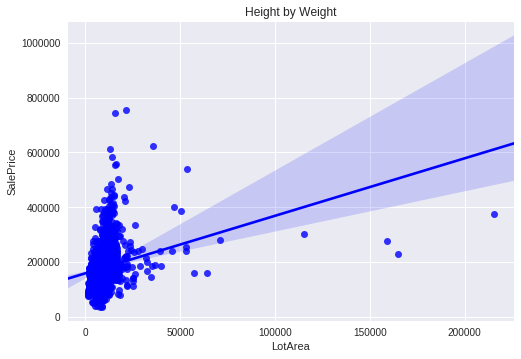

In [200]:
fig = sns.regplot(X['LotArea'], y, color='blue').set_title('Height by Weight')

Clearly not a very good linear relationship between just these two.

## 1.2 Now using the X variables that you feel like will be the best predictors of y use statsmodel to run the multiple regression between these variables and Y. You don't need to use every X variable in your dataset, in fact it's probably better if you don't. Just pick ones that you have already cleaned that seem the most relevant to house prices.

First, let's take a look at some X variables that might be relevant.

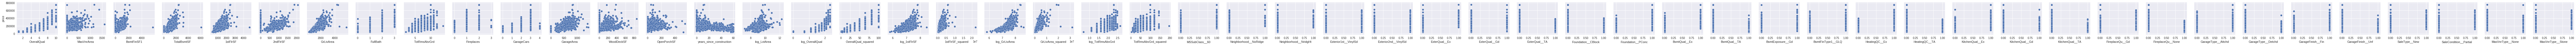

In [201]:
# create a dataframe to make pairplotting easier
df_clean = X
df_clean['price'] = y


# Generate a list of column headers not including price that are correlated
# with price

linear_relations = []

for column in df_clean.columns.drop('price'):
  if abs(df_clean['price'].corr(df_clean[column])) > 0.3:
    linear_relations.append(column)


# Only plot the scatterplot of x variables with our y variable
fig = sns.pairplot(data=df_clean, y_vars=['price'], x_vars=linear_relations)

In [202]:
# run multiple regression using these variables
# This is like using np.ones to add a vector of ones
X = sm.add_constant(df_clean[linear_relations])

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     205.0
Date:                Fri, 18 Jan 2019   Prob (F-statistic):               0.00
Time:                        00:11:29   Log-Likelihood:                -16963.
No. Observations:                1460   AIC:                         3.403e+04
Df Residuals:                    1406   BIC:                         3.432e+04
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

## 1.3 Identify the standard errors and P-Values of these coefficients in the output table. What is the interpretation of the P-values here?

The p-values here are interpreted as the probability that the coefficient has no predictive power. Higher p-values, such as that associated with "TotRmsAbvGrd_squared", indicate the coefficient does not have predictive power.

## 1.4 Remove outliers from your dataset and run the regression again. Do you see a change in some coefficients? Which seem to move the most?

In [203]:
# removing outlier values
df_clean_no_outliers = df_clean[(np.abs(stats.zscore(df_clean)) < 3).all(axis=1)].copy()

# re-run regression
X = sm.add_constant(df_clean_no_outliers[linear_relations])
y = df_clean_no_outliers['price']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Fri, 18 Jan 2019   Prob (F-statistic):                nan
Time:                        00:11:29   Log-Likelihood:                 351.38
No. Observations:                  27   AIC:                            -648.8
Df Residuals:                       0   BIC:                            -613.8
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1392: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1392: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1400: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1353: RuntimeWarning:

divide by zero encountered in double_scalars

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:1118: RuntimeWarning:

invalid value encountered in multiply

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/pytho

I'm not quite sure what to make of this, but it seems that many of our coefficients have decreased in importance and standard errors have increased. It's possible that removing outliers has made things worse because collinearity has increased.

## 1.5 Create a new log(y) variable and use it to run a log-linear regression of your variables using statmodels 

In [0]:
df_log = df_clean.copy()
df_log['price'] = np.log(df_log['price'])

# Generate a list of column headers not including price that are correlated
# with log(price)

log_linear_relations = []

for column in df_log.columns.drop('price'):
  if abs(df_clean['price'].corr(df_clean[column])) > 0.4:
    log_linear_relations.append(column)

In [205]:
# re-run regression
X = sm.add_constant(df_log[log_linear_relations])
y = df_log['price']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     276.0
Date:                Fri, 18 Jan 2019   Prob (F-statistic):               0.00
Time:                        00:11:29   Log-Likelihood:                 728.51
No. Observations:                1460   AIC:                            -1389.
Df Residuals:                    1426   BIC:                            -1209.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

## 2.1 Run a test for high levels of collinearity in your dataset. Calculate the Variance Inflation Factor for each X variable. Do you see VIF values greater than ten? If so try omitting those X variables and run your regression again. Do the standard errors change? Do the coefficients change? Do the coefficients seem to have an interpretation that matches your intuition?

In [206]:
vif_orig = [(X.columns[i],vif(X.values, i)) for i in range(X.shape[1])]
print(vif_orig)

[('const', 54315.41766733463), ('OverallQual', 954.9582100441895), ('MasVnrArea', 1.438365636744432), ('TotalBsmtSF', 4.062116354910806), ('1stFlrSF', 387.77353197304154), ('GrLivArea', 621.1348358181485), ('FullBath', 2.408947419670888), ('TotRmsAbvGrd', 1998.9992939319068), ('Fireplaces', 5.989289388766223), ('GarageCars', 5.851523821441662), ('GarageArea', 5.260282689955796), ('years_since_construction', 2.126823791692659), ('log_OverallQual', 178.89800316717205), ('OverallQual_squared', 367.3576991425586), ('log_1stFlrSF', 122.1205922461176), ('1stFlrSF_squared', 107.93035733520479), ('log_GrLivArea', 188.24158855862814), ('GrLivArea_squared', 168.88195844452483), ('log_TotRmsAbvGrd', 509.52581747791913), ('TotRmsAbvGrd_squared', 545.9250239121138), ('Neighborhood__NridgHt', 1.5387801449392695), ('ExterQual__Ex', 7.062908937139336), ('ExterQual__Gd', 32.557763996743006), ('ExterQual__TA', 32.06671706304594), ('Foundation__PConc', 2.528003553980077), ('BsmtQual__Ex', 1.9552563604275

Oof, we have some work to do. Some variables I clearly want to leave in, like 'OverallQual', even if its collinear with others. Others, like those relating to square footage, are likely causing some problems.

Let's drop some that seem less important and go from there.

In [0]:
X_new = X.drop(['1stFlrSF', 'log_OverallQual', 'OverallQual_squared', 'log_1stFlrSF', '1stFlrSF_squared',
               'log_TotRmsAbvGrd', 'TotRmsAbvGrd_squared', 'log_GrLivArea', 'TotRmsAbvGrd'], 
               axis=1).copy()

Now lets run the same analysis and see if that improved the VIF values.

In [208]:
vif_new = [(X_new.columns[i],vif(X_new.values, i)) for i in range(X_new.shape[1])]
print(vif_new)

[('const', 199.59604760005894), ('OverallQual', 3.5045797521843585), ('MasVnrArea', 1.410854301944349), ('TotalBsmtSF', 1.8138179380449428), ('GrLivArea', 16.634687581002428), ('FullBath', 2.331779500338553), ('Fireplaces', 5.904966409020913), ('GarageCars', 5.720112813184421), ('GarageArea', 5.120150244801761), ('years_since_construction', 2.0924920762070394), ('GrLivArea_squared', 14.023139357914934), ('Neighborhood__NridgHt', 1.5030101933676843), ('ExterQual__Ex', 6.245420929210899), ('ExterQual__Gd', 28.305383227791705), ('ExterQual__TA', 26.96281716258642), ('Foundation__PConc', 2.414017395648576), ('BsmtQual__Ex', 1.8609104467126154), ('BsmtQual__TA', 2.028260780420276), ('BsmtFinType1__GLQ', 1.4722962599276084), ('HeatingQC__Ex', 1.652333567429161), ('KitchenQual__Ex', 1.795513753855651), ('KitchenQual__TA', 2.16113707320795), ('FireplaceQu__None', 5.98097805230944), ('GarageFinish__Fin', 1.546492924824484), ('GarageFinish__Unf', 1.7308198967295927)]


Looks better, let's re-run the regression.

In [209]:
model = sm.OLS(y, X_new).fit()
predictions = model.predict(X_new) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     343.0
Date:                Fri, 18 Jan 2019   Prob (F-statistic):               0.00
Time:                        00:11:29   Log-Likelihood:                 661.11
No. Observations:                1460   AIC:                            -1272.
Df Residuals:                    1435   BIC:                            -1140.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

## 2.2 Variables that have high levels of multicollinearity should also be highly correlated with each other. Calculate your X matrix's correlation matrix to check if the variables highlighted by the VIF test truly are highly correlated.

In [210]:
X.corr()

,const,OverallQual,MasVnrArea,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageCars,...,Foundation__PConc,BsmtQual__Ex,BsmtQual__TA,BsmtFinType1__GLQ,HeatingQC__Ex,KitchenQual__Ex,KitchenQual__TA,FireplaceQu__None,GarageFinish__Fin,GarageFinish__Unf
const,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OverallQual,NaN,1.000000,0.407252,0.537808,0.476224,0.593007,0.550600,0.427452,0.396765,0.600671,...,0.568211,0.470780,-0.497957,0.433448,0.458225,0.425750,-0.553891,-0.438143,0.394996,-0.422479
MasVnrArea,NaN,0.407252,1.000000,0.360067,0.339850,0.388052,0.272999,0.279568,0.247015,0.361945,...,0.189236,0.333128,-0.185216,0.220765,0.167905,0.257000,-0.193251,-0.259577,0.194644,-0.219522
TotalBsmtSF,NaN,0.537808,0.360067,1.000000,0.819530,0.454868,0.323722,0.285573,0.339519,0.434585,...,0.307701,0.403166,-0.208065,0.317396,0.278664,0.360271,-0.311190,-0.309423,0.255437,-0.302520
1stFlrSF,NaN,0.476224,0.339850,0.819530,1.000000,0.566024,0.380637,0.409516,0.410531,0.439317,...,0.197188,0.377387,-0.222508,0.246405,0.206156,0.347257,-0.273566,-0.374518,0.238994,-0.253960
GrLivArea,NaN,0.593007,0.388052,0.454868,0.566024,1.000000,0.630012,0.825489,0.461679,0.467247,...,0.292764,0.309962,-0.278141,0.193521,0.255871,0.306604,-0.350179,-0.445299,0.284932,-0.251845
FullBath,NaN,0.550600,0.272999,0.323722,0.380637,0.630012,1.000000,0.554784,0.243671,0.469672,...,0.461667,0.237403,-0.494883,0.255327,0.336540,0.174759,-0.418698,-0.288713,0.282308,-0.388460
TotRmsAbvGrd,NaN,0.427452,0.279568,0.285573,0.409516,0.825489,0.554784,1.000000,0.326114,0.362289,...,0.192609,0.240581,-0.152746,0.063931,0.167205,0.247358,-0.210428,-0.330382,0.218513,-0.165388
Fireplaces,NaN,0.396765,0.247015,0.339519,0.410531,0.461679,0.243671,0.326114,1.000000,0.300789,...,0.103510,0.188224,-0.142974,0.114646,0.139792,0.213324,-0.186137,-0.900457,0.256468,-0.193903
GarageCars,NaN,0.600671,0.361945,0.434585,0.439317,0.467247,0.469672,0.362289,0.300789,1.000000,...,0.453421,0.356425,-0.448099,0.321159,0.331129,0.273275,-0.399449,-0.349501,0.340742,-0.221682


## 2.3 If you have varaibles with high Variance Inflation Factors, try excluding them from your regression. Do your standard errors improve? (get smaller). If high levels of multicollinearity are removed, the precision of the dataset should increase.

Already did this in 2.1

## 2.4 Recalculate your regression using Robust Standard Errors? What happens to your standard errors?

In [211]:
model = sm.OLS(y, X_new).fit(cov_type='HC3')
predictions = model.predict(X_new) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     303.1
Date:                Fri, 18 Jan 2019   Prob (F-statistic):               0.00
Time:                        00:11:30   Log-Likelihood:                 661.11
No. Observations:                1460   AIC:                            -1272.
Df Residuals:                    1435   BIC:                            -1140.
Df Model:                          24                                         
Covariance Type:                  HC3                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

The standard errors get a little bit larger when correcting for heteroskedasticity.

## 2.5 Use scatterplots or Seaborn's pairplot functionality to perform an eyeball test for potential variables that would be candidates for generating polynomial regressors. 

Done in data cleaning/feature engineering process.

## 2.6 Use seaborn's residplot to plot the distribution of each x variable's residuals. Does these plots indicate any other features that would be potential candidates for polynomial features.

For this, let's take a look at an x variable that is already being represented by a polynomial term in the regression, 'GrLivArea'. The regression currently has both the normal x value and the x^2 value.

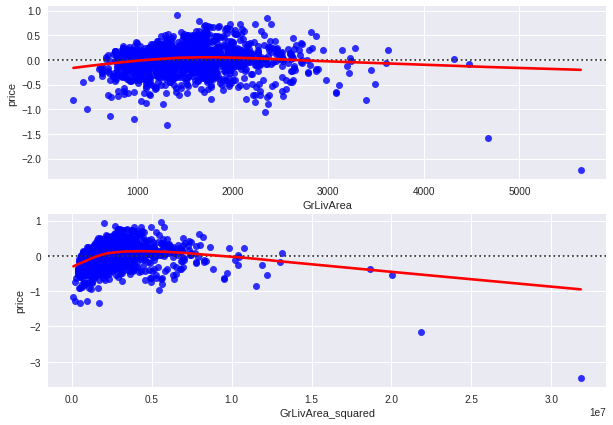

In [225]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(10,7))
sns.residplot(X_new['GrLivArea'], y, lowess=True, color="r", ax=ax[0], scatter_kws={'color':'blue'})
sns.residplot(X_new['GrLivArea_squared'], y, lowess=True, color="r", ax=ax[1], scatter_kws={'color':'blue'})
plt.show()

From these two residual subplots, we can see neither variable alone would capture the full relationship.

## 2.6 Feature Engineer the appropriate polynomial features from your analysis above and include them in one final log-polynomial, robust standard error, regression. Do the coefficients of this most advanced regression match your intuition better than the coefficients of the very first regression that we ran with the Statmodels library?

Already working with polynomial features at this point.

In general, yes the coefficients in the most advanced regression seem to match up with intuition.

## Testing Accuracy of Regression with New Parameters

In [0]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X_new, y,
                                                   test_size=0.25,
                                                   random_state=1000)

In [214]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [215]:
print ('Training R^2', lr.score(X_train, y_train))
print ('Train RMSE', mse(lr.predict(X_train), y_train)**0.5)

Training R^2 0.8473679609657025
Train RMSE 0.15523139295982047


In [216]:
print ('Test R^2', lr.score(X_test, y_test))
print ('Test RMSE', mse(lr.predict(X_test), y_test)**0.5)

Test R^2 0.8591290712559795
Test RMSE 0.1516416104287861


Some of the models on Tuesday (just running every single parameter and engineer parameter) were able to generate slightly higher R squared and slightly lower RMSE, but this model seems to generalize to test data very well.